# ***American Options***

Author: Youssef BOUZKRAOUI, Adel ADRAOUI

In [1]:
import numpy as np
import numpy.linalg as lng
import matplotlib.pyplot as plt
import time
import sys
import pandas as pd
import scipy.stats as stats
from scipy.stats import norm

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
r = 0.1
sigma = 0.3
T = 1
K = 100
Smin , Smax = 50 , 250

## 1  The Euler Forward (or Explicit Euler) Scheme
### Preliminaries

In [4]:
# Calculs communs entre les différents méthodes
def simulation(N, I):    
    results = {}  
    
    h = (Smax - Smin) / (I + 1)
    s = Smin + h * np.arange(1, I + 1)
    dt = T / N
    alpha = ((sigma ** 2) / (2 * (h ** 2))) * (s**2)
    beta = (r / (2 * h)) * s

    def u0(s):
        return max(K - s, 0)

    def uleft(t):
        return K - Smin

    def uright(t):
        return 0

    A = np.zeros((I, I))
    A[I-1,I-1]= 2 * alpha[I-1] + r
    for i in range(I - 1):
        A[i][i] = 2 * alpha[i] + r
        A[i + 1][i] = -alpha[i + 1] + beta[i + 1]
        A[i][i + 1] = -alpha[i] - beta[i]

    def q(t):
        y = np.zeros((I, 1))
        y[0] = (- alpha[0] + beta[0]) * uleft(t)
        y[I - 1] = (- alpha[I - 1] - beta[I - 1]) * uright(t)
        return y

    g = np.maximum(K - s, 0).reshape(I, 1)

    results['s'] = s
    results['h'] = h
    results['dt'] = dt
    results['A'] = A
    results['q'] = q
    results['g'] = g
    results['alpha'] = alpha
    results['beta'] = beta

    return results

## 1    Explicit Euler SCHEME (EE)

In [5]:
def EE_simulation(N, I, SCHEME='EE-AMER', afficher=True):
    if afficher:
        print('N=%3i' % N, 'I=%3i' % I, 'SCHEME=%s' % SCHEME)
    simu = simulation(N, I) 
    g = simu["g"]
    dt = simu["dt"]
    A = simu["A"]
    q = simu["q"]
    U = g
    for n in range(N):
        t = n * dt
        U = np.maximum(U - dt * (A @ U + q(t)) , g)
    return U

In [6]:
def plot_payoff_and_scheme(s, U, K):    
    plt.figure(figsize=(8, 6))
    plt.plot(s, g, label='Payoff du Put')
    plt.plot(s, U.flatten(), label='Schéma de différence finie')
    plt.title('Comparaison Payoff et Schéma de différence finie pour un Put')
    plt.xlabel('Prix de l\'actif sous-jacent')
    plt.ylabel('Valeur')
    plt.legend()
    plt.grid(True)
    plt.show()

N= 20 I= 20 SCHEME=EE-AMER


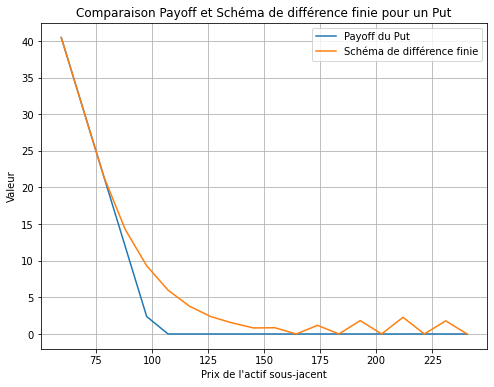

In [7]:
s = simulation(20, 20)['s']
U = EE_simulation(20, 20)
g = simulation(20, 20)['g']
plot_payoff_and_scheme(s, U, K)

#### Test the Euler Forward Scheme EE

In [8]:
def check_stability_and_positivity(U):
    is_stable = np.linalg.norm(U, np.inf) < 1000 #### 1000 valeur prise au hasard
    is_positive = np.all(U >= 0)
    return is_stable, is_positive

For N=20, I=50: Stability - False, Positivity - True
For N=20, I=100: Stability - False, Positivity - True


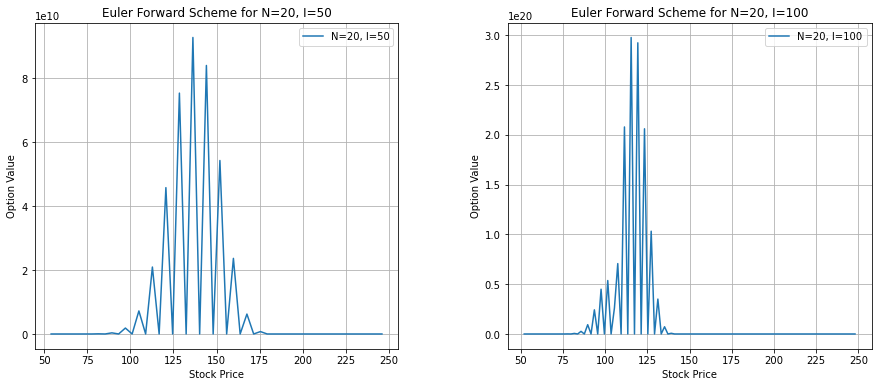

In [9]:
## UNSTABLE BEHAVIOR WITH I =50 and N=20
N = 20
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))  
axes = axes.flatten()  

for idx, I in enumerate([50, 100]):
    U = EE_simulation(N, I, afficher=False)
    is_stable, is_positive = check_stability_and_positivity(U)
    print(f"For N={N}, I={I}: Stability - {is_stable}, Positivity - {is_positive}")
    s = simulation(N, I)['s']
    axes[idx].plot(s, U.flatten(), label=f'N={N}, I={I}')
    axes[idx].set_title(f'Euler Forward Scheme for N={N}, I={I}')
    axes[idx].set_xlabel('Stock Price')
    axes[idx].set_ylabel('Option Value')
    axes[idx].legend()
    axes[idx].grid(True)

plt.subplots_adjust(wspace=0.3, hspace=0.3)  
plt.show()

#### With the help of the `check_stability_and_positivity` function, we can indeed verify that:
#### There is an unstable behavior with other parameters (such as I = 50 and N=20)

\begin{align} 
& U_j^n = v(t_n,s_j) ~~ et ~~ v = v(t=T=t_N,s_j=Sval)= U_{j=\frac{I+1}{5}}^{n=N} \\
& Because, T = N \Delta T ~~ s_j = Sval ==> j = \frac{Sval - Smin}{Smax - Smin} (I+1) = \frac{I+1}{5} ~~ for ~~  Sval=90
\end{align}

In [10]:
### APPROXIMATION Of V_bar
def table(Sval, simulation_function, valeurs_I, valeurs_N, Method):
    data = []
    for I, N in zip(valeurs_I, valeurs_N):
        start_time = time.time()
        j = int((I+1)/5)
        v_bar = simulation_function(N, I, SCHEME= Method, afficher=False)[j-1][0]
        tcpu = time.time() - start_time
        data.append([I, N, v_bar, np.nan, np.nan, tcpu])  

    df = pd.DataFrame(data, columns=['I', 'N', 'v', 'err', 'ord',  'tcpu'])

    # Calcul de 'error'  'ord' 
    df['err'] = np.abs((df['v'] - df['v'].shift(-1)).shift(1))
    df['err'].iloc[0] = 0  
    df['ord'] = np.log(np.abs(df['err'] / df['err'].shift(-1))) / (2* np.log(2))
    df['ord'].iloc[0] = 0  
    return df

In [11]:
Sval = 90
valeurs_I = [19, 39, 79,159,319]
valeurs_N = [int((2 *(x+1)**2)/10) for x in valeurs_I]
table(Sval,EE_simulation,valeurs_I,valeurs_N,"EE-AMER")[:5]

,I,N,v,err,ord,tcpu
0,19,80,12.947098,0.000000,0.000000,0.001151
1,39,320,13.064717,0.117619,0.695390,0.006016
2,79,1280,13.109572,0.044855,1.222892,0.020572
3,159,5120,13.117805,0.008233,0.957650,0.143276
4,319,20480,13.119987,0.002183,NaN,0.728329


### 2/ A First Implicit Scheme : The splitting scheme

The scheme can be written in the vector form as : 
\begin{align} 
& \frac{U^{n+1,(1)} - U^{n,(1)}}{\Delta t} + AU^{n+1,(1)} + q(t_{n+1}) = 0, & n = 0  , \ldots, N-1 \\
&  with : U^0 = (\phi(s_i))_{1 \leq i \leq I})
\end{align}

So, after all calculations are done, we obtain: : 
\begin{align} 
& (I_I + \Delta t A)U^{n+1,(1)} = U^{n,(1)}  - \Delta t . q(t_{n+1}) , & n = 0  , \ldots, N-1 \\
&  with : U^0 = (\phi(s_i))_{1 \leq i \leq I}) ~~ ; ~~ q(t_{n+1}) = q(t_{n} + \Delta t)
\end{align}
Then, we compute : 
\begin{align} 
U^{n+1} = max(U^{n+1,(1)} , g)
\end{align}

In [12]:
def IE_simulation(N, I, SCHEME='EI-AMER-SPLIT', afficher=True):
    if afficher:
        print('N=%3i' % N, 'I=%3i' % I, 'SCHEME=%s' % SCHEME)
    simu = simulation(N, I)
    g = simu["g"]
    dt = simu["dt"]
    A = simu["A"]
    q = simu["q"]
    U_1 = g
    for n in range(N):
        t = n * dt
        U_1 = lng.solve(np.eye(I) + dt * A , U_1 - dt * q(t + dt)).reshape(-1,1)
    U = np.maximum(U_1 , g)
    return U

N= 20 I= 20 SCHEME=EI-AMER-SPLIT


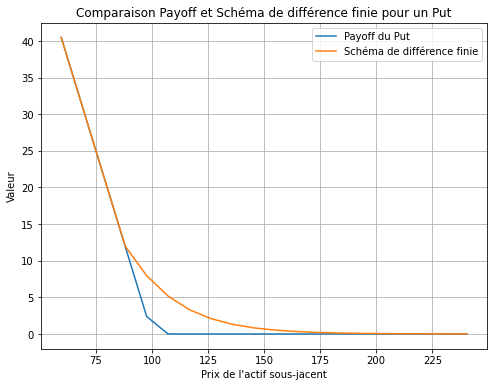

In [13]:
s = simulation(20, 20)['s']
U = IE_simulation(20, 20)
g = simulation(20, 20)['g']
plot_payoff_and_scheme(s, U, K)

For N=20, I=50: Stability - True, Positivity - True
For N=20, I=100: Stability - True, Positivity - True


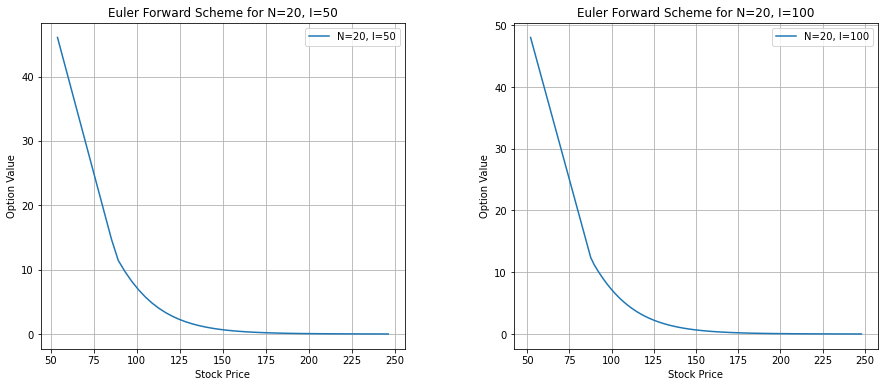

In [14]:
N = 20
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))  
axes = axes.flatten()  

for idx, I in enumerate([50, 100]):
    U = IE_simulation(N, I, afficher=False)
    is_stable, is_positive = check_stability_and_positivity(U)
    print(f"For N={N}, I={I}: Stability - {is_stable}, Positivity - {is_positive}")
    s = simulation(N, I)['s']
    axes[idx].plot(s, U.flatten(), label=f'N={N}, I={I}')
    axes[idx].set_title(f'Euler Forward Scheme for N={N}, I={I}')
    axes[idx].set_xlabel('Stock Price')
    axes[idx].set_ylabel('Option Value')
    axes[idx].legend()
    axes[idx].grid(True)

plt.subplots_adjust(wspace=0.3, hspace=0.3)  
plt.show()

In [15]:
Sval = 90
valeurs_I = [20 * 2**k -1 for k in range(5)]
valeurs_N = [20 * 2**k  for k in range(5)]
table(Sval,IE_simulation,valeurs_I,valeurs_N,"EI-AMER-SPLIT")[:5]

,I,N,v,err,ord,tcpu
0,19,20,10.938707,0.000000,0.000000,0.002678
1,39,40,11.045953,0.107246,0.972196,0.006022
2,79,80,11.073818,0.027865,0.888805,0.012083
3,159,160,11.081945,0.008127,0.804198,0.086208
4,319,320,11.084611,0.002665,NaN,1.176622


#### Crank-Nicolson ($\theta  =  \frac{1}{2}$ sheme)

The scheme can be written in the vector form as : 
\begin{align} 
& \frac{U^{n+1} - U^n}{\Delta t} + \frac{1}{2}A(U^{n+1}+U^n) + \frac{1}{2}(q(t_{n+1}+q(t_{n})) = 0, & n = 0  , \ldots, N-1 \\
&  with : U^0 = (\phi(s_i))_{1 \leq i \leq I})
\end{align}

So, after all calculations are done, we obtain: : 
\begin{align} 
& (I_I + \frac{\Delta t}{2} A)U^{n+1} = U^{n}  - \frac{\Delta t}{2} . (AU^{n}+q(t_{n})+q(t_{n+1})) , & n = 0  , \ldots, N-1 \\
&  with : U^0 = (\phi(s_i))_{1 \leq i \leq I})  ~~ ; ~~ q(t_{n+1}) = q(t_{n} + \Delta t)
\end{align}
Then, we compute : 
\begin{align} 
U^{n+1} = max(U^{n+1,(1)} , g)
\end{align}

In [16]:
def CN_simulation(N, I, SCHEME='CN-AMER-SPLIT', afficher=True):
    if afficher:
        print('N=%3i' % N, 'I=%3i' % I, 'SCHEME=%s' % SCHEME)
    simu = simulation(N, I)
    g = simu["g"]
    dt = simu["dt"]
    A = simu["A"]
    q = simu["q"]
    U_1 = g
    for n in range(N):
        t = n * dt
        U_1 = lng.solve(np.eye(I) + (dt/2) * A , U_1 - (dt/2) * ( A@U_1 + q(t) + q(t+dt))).reshape(-1,1)
    U = np.maximum(U_1 , g)
    return U

N= 20 I= 20 SCHEME=CN-AMER-SPLIT


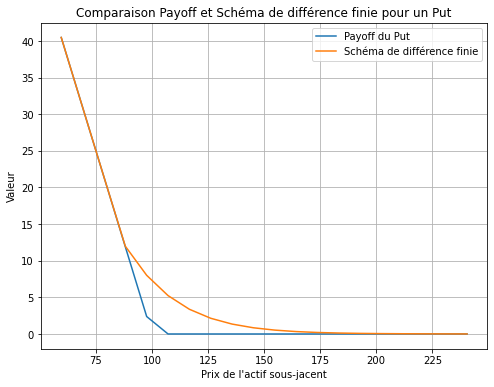

In [17]:
s = simulation(20, 20)['s']
U = CN_simulation(20, 20)
g = simulation(20, 20)['g']
plot_payoff_and_scheme(s, U, K)

In [18]:
Sval = 90
valeurs_I = [20 * 2**k -1 for k in range(5)]
valeurs_N = [20 * 2**k  for k in range(5)]
table(Sval,CN_simulation,valeurs_I,valeurs_N,"CN-AMER-SPLIT")[:5]

,I,N,v,err,ord,tcpu
0,19,20,10.962498,0.000000,0.000000,0.002000
1,39,40,11.056759,0.094261,1.039949,0.005778
2,79,80,11.079054,0.022296,1.011815,0.012630
3,159,160,11.084538,0.005483,1.003095,0.091349
4,319,320,11.085903,0.001365,NaN,1.170436


### 3/ Implicit Euler Scheme :
#### 3.1/ PSOR Algorithm

\begin{align} 
& B := I_d - \Delta t A ~~ and ~~ b:= U^n - \Delta t q(t_{n+1})
\end{align}
As in the first part (équation (5)). We have
\begin{align} 
& min(Lx^{k+1} - (b - Ux^{k}) , x^{k+1} - g) = 0 \\
& \Longleftrightarrow Lx - (b - Ux^{k}) = 0 ~~ and ~~ x^{k+1} = max(x,g)
\end{align}
So,
\begin{align*}
Lx &= b - Ux \\
\Longleftrightarrow \sum_{j \leq i} L_{ij}x_j &= b_i - \sum_{j > i} U_{ij}x_j ~~ L ~ Lower ~ triangular ~~ and ~ U ~ strict ~ Upper ~ triangular \\
\Longleftrightarrow \sum_{j \leq i} B_{ij} x_j &= b_i - \sum_{j > i} B_{ij}x_j \\
\Longleftrightarrow B_{ii} x_i + \sum_{j > i} B_{ij}x_j &= b_i - \sum_{j > i} B_{ij}x_j \\
\Longleftrightarrow 
\begin{cases}
 B_{ii} x_i = b_i - \sum_{j \neq i} B_{ij}x_j \Longleftrightarrow   x_i = \frac{b_i - \sum_{j \neq i} B_{ij}x_j}{B_{ii}},B_{ii}\neq 0\\
 x_i^{k+1} = max(x_i,g_i)
\end{cases}
\end{align*}
Thus the pseudo-algorithm in question

In [19]:
def PSOR(N, B, b, x0, g, eta, kmax):
    x = x0.copy()
    for k in range(kmax):
        xold = x.copy()
        for i in range(N):  # Assurez-vous que N est le nombre correct d'éléments dans x
            sum_j = sum(B[i, j] * x[j] for j in range(N) if j != i)
            x[i] = (b[i] - sum_j) / B[i, i]
            x[i] = max(x[i], g[i])
        # Debug prints
        err1 = np.linalg.norm(x - xold)
        err2 = np.linalg.norm(np.minimum(np.dot(B, x) - b, x - g))
        print(f"k={k:3d} | x-xold={err1:.10f} | min(Bx-b, x-g)={err2:.10f}")
        if err1 < eta:
            break
    else:
        print("WARNING MESSAGE: Convergence not achieved within kmax iterations.")
    return x

In [20]:
def EI_simulation_PSOR(N, I, eta, kmax, SCHEME='EI-AMER-PSOR', afficher=True):
    if afficher:
        print(f'N={N:3d} I={I:3d} SCHEME={SCHEME}')
    simu = simulation(N, I)
    g = simu["g"]
    dt = simu["dt"]
    A = simu["A"]
    B = np.identity(I) + dt * A
    q = simu["q"]
    x0 = np.zeros_like(g)
    U = g.copy()  
    for n in range(1, N+1):  # Commence à n=1 car U^0=g est déjà défini
        t = n * dt
        b = U - dt * q(t)  # Mettre à jour b en utilisant U de l'étape précédente
        U = PSOR(I, B, b, x0, g, eta, kmax)  # Mise à jour de U
    return U

N= 10 I= 99 SCHEME=EI-AMER-PSOR
k=  0 | x-xold=140.0040098885 | min(Bx-b, x-g)=10.9855737513
k=  1 | x-xold=0.6883936884 | min(Bx-b, x-g)=7.1214082591
k=  2 | x-xold=0.5099007809 | min(Bx-b, x-g)=5.4876971909
k=  3 | x-xold=0.4045098001 | min(Bx-b, x-g)=4.5188294916
k=  4 | x-xold=0.3418116801 | min(Bx-b, x-g)=3.7599443405
k=  5 | x-xold=0.2844852335 | min(Bx-b, x-g)=3.1934195761
k=  6 | x-xold=0.2468459450 | min(Bx-b, x-g)=2.7629460390
k=  7 | x-xold=0.2138461600 | min(Bx-b, x-g)=2.3926820930
k=  8 | x-xold=0.1848436752 | min(Bx-b, x-g)=2.0764168435
k=  9 | x-xold=0.1599479427 | min(Bx-b, x-g)=1.8089414616
k= 10 | x-xold=0.1396072843 | min(Bx-b, x-g)=1.5980433601
k= 11 | x-xold=0.1239894903 | min(Bx-b, x-g)=1.4171705564
k= 12 | x-xold=0.1098148955 | min(Bx-b, x-g)=1.2579198677
k= 13 | x-xold=0.0972206431 | min(Bx-b, x-g)=1.1179508088
k= 14 | x-xold=0.0861203248 | min(Bx-b, x-g)=0.9950235488
k= 15 | x-xold=0.0763682513 | min(Bx-b, x-g)=0.8870335929
k= 16 | x-xold=0.0678095092 | min(Bx-

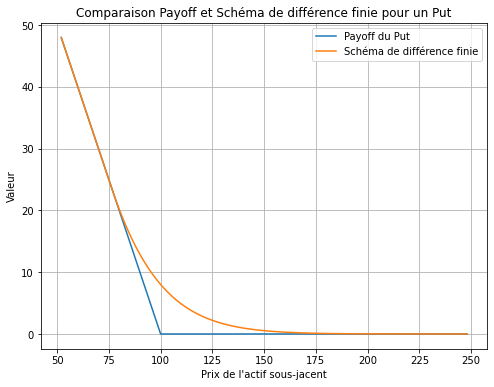

In [21]:
s = simulation(10, 99)['s']
U = EI_simulation_PSOR(10, 99,1e-2,100)
g = simulation(10, 99)['g']
plot_payoff_and_scheme(s, U, K)

When the value of \( I \) increases, resulting in a larger system of equations, the PSOR method requires more iterations to converge at each time step due to the increased complexity of the problem. This is because the number of operations needed to perform matrix-vector multiplications and updates increases with the system size. For instance, with parameters \( $\sigma$ = 0.3 \), \( N = 10 \), and \( I + 1 = 100 \), the computational workload for each iteration grows, and thus, the method experiences a slowdown, demonstrating that the PSOR algorithm's performance is sensitive to the dimensionality of the problem.

#### 3.2/ Semi-smooth Newton's Method

In [22]:
def semi_smooth_newton(B, b, g, x0, eps, kmax, PRINT=False):
    k = 0
    x = x0
    err = eps + 1
    Id = np.eye(B.shape[0])  # Identity matrix

    while k < kmax and err > eps:
        k += 1
        xold = x.copy()

        # Definition of F = F(x) and Fp = F'(x):
        F = np.minimum(B @ x - b, x - g)
        Fp = Id.copy()
        M = (B @ x - b) - (x - g)
        i = np.where(M <= 0)[0]  # Indices where the min is achieved by Bx - b
        Fp[i, :] = B[i, :]

        # Definition of new x
        x = x - np.linalg.solve(Fp, F)

        # Estimator for convergence
        err = np.linalg.norm(np.minimum(B @ x - b, x - g), np.inf)

        if PRINT:
            print(f'k={k:5d}, err={err:12.6f}, norm(x-xold)={np.linalg.norm(x-xold):10.6f}')
        result ={}
        result["x"] = x
        result["k"] = k
        result["err"] = err

    return result

In [23]:
def EI_simulation_NEWTON(N, I, SCHEME='EI-AMER-NEWTON', afficher=True):
    if afficher:
        print('N=%3i' % N, 'I=%3i' % I, 'SCHEME=%s' % SCHEME)
    simu = simulation(N, I)
    g = simu["g"]
    dt = simu["dt"]
    A = simu["A"]
    B = np.identity(I) + dt * A
    q = simu["q"]
    x0 = np.zeros_like(g)
    U = g.copy()  
    for n in range(1,N+1):
        t = n * dt
        b = U - dt * q(t)
        U = semi_smooth_newton(B, b, g, x0, eps=1e-6, kmax=100)["x"]
    return U

N= 20 I= 50 SCHEME=EI-AMER-NEWTON


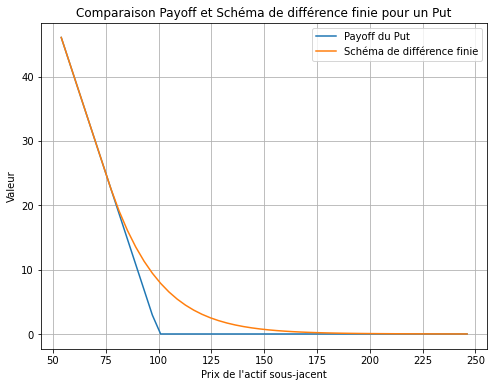

In [24]:
s = simulation(20, 50)['s']
U = EI_simulation_NEWTON(20, 50)
g = simulation(20, 50)['g']
plot_payoff_and_scheme(s, U, K)

In [25]:
valeurs_I = [20 * 2**k for k in range(5)] ### I = N
table(Sval,EI_simulation_NEWTON,valeurs_I,valeurs_I,"EI-AMER-NEWTON")[:5]

,I,N,v,err,ord,tcpu
0,20,20,14.135376,0.000000,0.000000,0.007535
1,40,40,13.620816,0.514560,0.567128,0.013785
2,80,80,13.386399,0.234418,0.416071,0.037410
3,160,160,13.254727,0.131671,0.493053,0.240840
4,320,320,13.188255,0.066473,NaN,1.631719


In [26]:
## N = I/10
valeurs_I = [20 * 2**k for k in range(5)]
valeurs_N =[int(x/10) for x in valeurs_I]
table(Sval,EI_simulation_NEWTON,valeurs_I,valeurs_N,"EI-AMER-NEWTON")[:5]

,I,N,v,err,ord,tcpu
0,20,2,13.763491,0.000000,0.000000,0.001680
1,40,4,13.384832,0.378660,0.739279,0.003231
2,80,8,13.248951,0.135881,0.509336,0.005510
3,160,16,13.181884,0.067067,0.538716,0.042488
4,320,32,13.150103,0.031781,NaN,0.369625


#### 3.3/ Brennan and Schwartz algorithm (in second lecture)

In [27]:
### UL Decompsition #######
def ul_decomp(B):
    N = B.shape[0]
    U = np.eye(N)
    L = np.zeros((N, N))
    
    # Initialisation de d_N
    d_N = B[-1, -1]
    L[-1, -1] = d_N
    
    for i in reversed(range(N - 1)):
        # Calcul de l_i et u_i selon les formules données
        l_i = B[i + 1, i]
        u_i = B[i, i + 1] / L[i + 1, i + 1]
        d_i = B[i, i] - u_i * l_i
        
        # Remplissage des matrices L et U
        L[i, i] = d_i
        L[i + 1, i] = l_i
        U[i, i + 1] = u_i

    return U, L

def test_ul_decomposition(B, U, L):
    """
    Tests that the UL decomposition is correct by verifying that A = UL
    """
    U,L = ul_decomp(B)
    reconstructed_B = np.dot(U, L)
    # Calcul de la différence norme entre B et reconstructed_B
    norm_diff = np.linalg.norm(B - reconstructed_B, ord=np.inf)
    return norm_diff

# Utilisation de la fonction de test
A = simulation(20, 10)['A']
dt = simulation(20, 10)['dt']
B = np.identity(10) + dt * A
U, L = ul_decomp(B)
norm_diff = test_ul_decomposition(B, U, L)
print(f'Norm of the difference between B and U@L: {norm_diff}')

Norm of the difference between B and U@L: 2.7755575615628914e-17


The norm of B - UL is close to Zero ~ 2.7755575615628914e-17

In [28]:
def descente_p(L, c, g):
    n = len(c)
    x = np.zeros(n)
    for i in range(n):
        sum_Lx = np.dot(L[i, :i], x[:i])
        x[i] = max((c[i] - sum_Lx) / L[i, i], g[i])
    return x

def EI_simulation_UL(N, I, SCHEME='EI-AMER-UL', afficher=True):
    if afficher:
        print('N=%3i' % N, 'I=%3i' % I, 'SCHEME=%s' % SCHEME)
    simu = simulation(N,I)
    g = simu["g"].flatten()
    dt = simu["dt"]
    A = simu["A"]
    B = np.identity(I) + dt * A
    U,L = ul_decomp(B)
    q = simu["q"]
    x = g.copy()  
    for n in range(1,N+1):
        t = n * dt
        b = (x - dt * q(t).flatten())
        c = np.linalg.solve(U, b) # Solve Uc = b for c (upwind step)
        x = descente_p(L, c.flatten(), g.flatten()) # Solve the downwind problem
        print(np.linalg.norm(np.minimum(np.dot(L, x) - c.flatten(), x - g.flatten()), np.inf)) 
    return x

N= 20 I= 10 SCHEME=EI-AMER-UL
6.938893903907228e-18
5.204170427930421e-18
2.7755575615628914e-17
5.551115123125783e-17
4.440892098500626e-16
4.440892098500626e-16
4.440892098500626e-16
1.7763568394002505e-15
1.7763568394002505e-15
1.734723475976807e-18
1.7763568394002505e-15
1.1102230246251565e-16
1.7763568394002505e-15
1.7763568394002505e-15
1.7763568394002505e-15
0.0
8.673617379884035e-19
1.7763568394002505e-15
2.220446049250313e-16
1.7763568394002505e-15


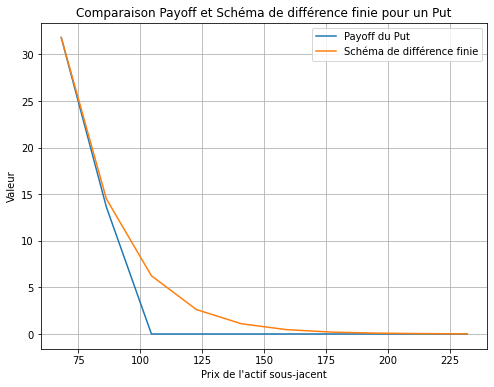

In [29]:
s = simulation(20, 10)['s']
U = EI_simulation_UL(20, 10)
g = simulation(20, 10)['g']
plot_payoff_and_scheme(s, U, K)

At each time iteration we have the norm of min(Bx-b,x-g) is close to 0

### 4/ Higher order schemes :

The BDF (Backward Differentiation Formula) scheme is a second-order accurate time integration method for differential equations. The BDF scheme uses information from two previous time levels to estimate the derivative at the current time step, which makes it more accurate than the first-order implicit Euler method but also more complex.

In [30]:
from scipy.optimize import fsolve

def obstacle_function(U_n_plus_1, U_n, U_n_minus_1, A, delta_t, q_n_plus_1, g):
    ### Sheme defined in the question
    return np.minimum(3 * U_n_plus_1 - 4 * U_n + U_n_minus_1 + 2 * delta_t * (A @ U_n_plus_1 + q_n_plus_1), U_n_plus_1 - g)

def BDF_simulation(N, I, SCHEME='BDF-AMER', afficher=True):
    if afficher:
        print('N=%3i' % N, 'I=%3i' % I, 'SCHEME=%s' % SCHEME)
    simu = simulation(N, I)
    g = simu["g"]
    dt = simu["dt"]
    A = simu["A"]
    q = simu["q"]
    # Initialize the solution matrix with zeros
    U = np.zeros((N+1,len(g)))
    U[0] = g.flatten()  # Initial condition
    # Compute U^1 with the Implicit Euler scheme
    U[1] = IE_simulation(1, I,afficher=False).flatten()

    # Compute subsequent steps with the BDF scheme
    for n in range(1, N):
        U_n = U[n]
        U_n_minus_1 = U[n-1]
        q_n_plus_1 = q((n+1) * dt).flatten()
        # Solve for U_n_plus_1 using fsolve for the obstacle problem
        U[n+1] = fsolve(lambda U_n_plus_1: obstacle_function(U_n_plus_1, U_n, U_n_minus_1, A, dt, q_n_plus_1, g.flatten()), U_n)

    return U[N][:, np.newaxis]

N= 20 I= 10 SCHEME=BDF-AMER


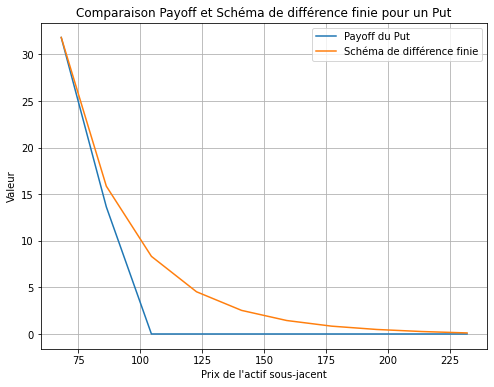

In [31]:
s = simulation(20, 10)['s']
U = BDF_simulation(20, 10)
g = simulation(20, 10)['g']
plot_payoff_and_scheme(s, U, K)

In [32]:
valeurs_I = [20 * 2**k for k in range(5)] ### I = N
table(Sval,BDF_simulation,valeurs_I,valeurs_I,"BDF-AMER")[:5]

,I,N,v,err,ord,tcpu
0,20,20,15.247465,0.000000,0.000000,0.014007
1,40,40,14.974197,0.273268,0.127576,0.056337
2,80,80,14.745227,0.228971,0.499773,0.300233
3,160,160,14.630705,0.114521,0.478734,3.268403
4,320,320,14.571731,0.058974,NaN,38.557411


In [33]:
## N = I/10
valeurs_I = [20 * 2**k for k in range(5)]
valeurs_N =[int(x/10) for x in valeurs_I]
table(Sval,BDF_simulation,valeurs_I,valeurs_N,"BDF-AMER")[:5]

,I,N,v,err,ord,tcpu
0,20,2,13.741765,0.000000,0.000000,0.001995
1,40,4,14.514993,0.773227,1.789166,0.010310
2,80,8,14.579725,0.064732,0.529088,0.061939
3,160,16,14.548638,0.031087,0.416580,0.512461
4,320,32,14.531189,0.017449,NaN,5.799932
